## Let's try out a neural network

## This turned into a weird experiment with using neural nets and regression to classify Fraudulant transactions

In [36]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [37]:
# from fastbook import *
# from utils import *
from fastai.tabular.all import *
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier
# #from dtreeviz.trees import *
# from IPython.display import Image, display_svg, SVG
# from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
# from sklearn.metrics import accuracy_score, roc_auc_score 
from sklearn.metrics import roc_auc_score 


path = Path('/Users/baranserajelahi/Codes/fraud-detection-pytorch-scikit-fastai/data')
path = Path('/home/jupyter/fraud-detection-pytorch-scikit-fastai/data')
Path.BASE_PATH = path
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 300

In [38]:
xs_final = (path/'xs_final.pkl').load()
train_ss = pd.read_csv(path/'train_ss.csv', index_col=[0], low_memory=False)
dep_var = 'isFraud'

In [39]:
df_nn = train_ss[['C5',
 'D3',
 'C14',
 'C13',
 'C4',
 'D2',
 'C1',
 'C8',
 'C2',
 'R_emaildomain',
 'D5',
 'M4',
 'card6',
 'C11',
 'C10',
 'TransactionDT',
 'id_20',
 'ProductCD',
 'M5',
 'C12',
 'TransactionAmt',
 'D1',
 'DeviceType',
 'D8',
 'addr2',
 'D15',
 'id_31',
 'C6',
 'card2'] + [dep_var]]

In [40]:
#assert len(xs_final.columns)==(len(df_nn.columns)-1)

AttributeError: 'DataFrame' object has no attribute '_data'

In [41]:
df_nn.head()

,C5,D3,C14,C13,C4,D2,C1,C8,C2,R_emaildomain,D5,M4,card6,C11,C10,TransactionDT,id_20,ProductCD,M5,C12,TransactionAmt,D1,DeviceType,D8,addr2,D15,id_31,C6,card2,isFraud
57195,2.0,463.0,2.0,2.0,0.0,NaN,2.0,0.0,1.0,NaN,288.0,NaN,debit,1.0,0.0,1316341,NaN,W,NaN,0.0,418.95,472.0,NaN,NaN,87.0,288.0,NaN,1.0,490.0,0
312877,1.0,NaN,4.0,12.0,0.0,NaN,5.0,0.0,3.0,NaN,196.0,M0,debit,1.0,0.0,7780176,NaN,W,F,0.0,59.00,0.0,NaN,NaN,87.0,330.0,NaN,2.0,268.0,0
195195,0.0,0.0,1.0,8.0,0.0,51.0,1.0,0.0,2.0,NaN,0.0,M0,debit,2.0,0.0,4394717,NaN,W,T,0.0,29.00,51.0,NaN,NaN,87.0,51.0,NaN,1.0,417.0,1
21600,0.0,NaN,1.0,1.0,0.0,NaN,1.0,0.0,1.0,NaN,NaN,M1,debit,1.0,0.0,572518,NaN,W,T,0.0,24.00,0.0,NaN,NaN,87.0,0.0,NaN,0.0,194.0,0
12253,3.0,7.0,2.0,18.0,0.0,484.0,2.0,0.0,2.0,NaN,NaN,NaN,debit,3.0,0.0,348181,NaN,W,NaN,0.0,57.95,484.0,NaN,NaN,87.0,NaN,NaN,1.0,215.0,0


In [42]:
df_nn.columns

Index(['C5', 'D3', 'C14', 'C13', 'C4', 'D2', 'C1', 'C8', 'C2', 'R_emaildomain',
       'D5', 'M4', 'card6', 'C11', 'C10', 'TransactionDT', 'id_20',
       'ProductCD', 'M5', 'C12', 'TransactionAmt', 'D1', 'DeviceType', 'D8',
       'addr2', 'D15', 'id_31', 'C6', 'card2', 'isFraud'],
      dtype='object')

In [43]:
df_nn['isFraud']

57195     0
312877    0
195195    1
21600     0
12253     0
         ..
224165    0
322952    1
449491    0
343893    0
125898    0
Name: isFraud, Length: 59054, dtype: int64

In [82]:
df_nn['isFraud'] = df_nn['isFraud'].astype('category')

SettingWithCopyError: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [83]:
cont = ['C5', 'D3', 'C14', 'C13', 'C4', 'D2', 'C1', 'C8', 'C2', 'D5', 'C11', 'C10',
        'C12', 'D1', 'D8', 'D15', 'C6', 'TransactionDT', 'TransactionAmt']
cat =  ['R_emaildomain', 'M4', 'M5', 'card6', 'id_20', 'ProductCD',
        'DeviceType', 'addr2', 'id_31', 'card2']

In [84]:
assert len(df_nn.columns)==(len(cat)+len(cont)+1)

In [85]:
df_nn[cat].nunique()

R_emaildomain     59
M4                 3
M5                 2
card6              4
id_20            206
ProductCD          5
DeviceType         2
addr2             27
id_31            107
card2            499
dtype: int64

There are NOT a numner of categorical variables where the number of categories has high cardinality, so deep learning might NOT help us in this senerio.

In [86]:
# The rows with TransactionDT <= 12579058 comprise the first 80% of the data (approximately)
cut_off = math.floor((train_ss['TransactionDT'].max() - train_ss['TransactionDT'].min())*0.8)
cut_off

12579784

In [87]:
cond = train_ss['TransactionDT'] <= cut_off
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [88]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn, procs_nn, cat, cont,
                     splits=splits, y_names=dep_var)
to_nn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [89]:
to_nn['isFraud']

57195     0
312877    0
195195    1
21600     0
12253     0
         ..
585191    0
582517    0
493713    0
526363    0
500247    0
Name: isFraud, Length: 59054, dtype: int8

In [90]:
dls = to_nn.dataloaders(1024)

In [91]:
dls.xs

,R_emaildomain,M4,M5,card6,id_20,ProductCD,DeviceType,addr2,id_31,card2,D3_na,D2_na,D5_na,D1_na,D8_na,D15_na,C5,D3,C14,C13,C4,D2,C1,C8,C2,D5,C11,C10,C12,D1,D8,D15,C6,TransactionDT,TransactionAmt
57195,0,0,0,3,0,5,0,21,0,390,1,2,1,1,2,1,-0.134384,9.471498,-0.123058,-0.224706,-0.061955,-0.280162,-0.089028,-0.056906,-0.090942,4.260183,-0.096037,-0.057582,-0.051114,2.468850,-0.154975,0.805232,-0.109859,-1.245707,1.240415
312877,0,1,1,3,0,5,0,21,0,168,2,2,1,1,2,1,-0.174292,-0.233869,-0.085467,-0.150241,-0.061955,-0.280162,-0.068799,-0.056906,-0.079297,2.774099,-0.096037,-0.057582,-0.051114,-0.590402,-0.154975,1.033601,-0.097012,0.519150,-0.328971
195195,0,1,2,3,0,5,0,21,0,317,1,1,1,1,2,1,-0.214200,-0.404513,-0.141853,-0.180027,-0.061955,-0.634464,-0.095771,-0.056906,-0.085119,-0.391905,-0.086453,-0.057582,-0.051114,-0.259847,-0.154975,-0.483425,-0.109859,-0.405201,-0.459771
21600,0,2,2,3,0,5,0,21,0,94,2,2,2,1,2,1,-0.214200,-0.233869,-0.141853,-0.232152,-0.061955,-0.280162,-0.095771,-0.056906,-0.090942,-0.246527,-0.096037,-0.057582,-0.051114,-0.590402,-0.154975,-0.760731,-0.122707,-1.448797,-0.481571
12253,0,0,0,3,0,5,0,21,0,115,1,1,2,1,2,2,-0.094476,-0.255200,-0.123058,-0.105562,-0.061955,2.700589,-0.089028,-0.056906,-0.085119,-0.246527,-0.076868,-0.057582,-0.051114,2.546627,-0.154975,-0.499737,-0.109859,-1.510049,-0.333549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224165,55,1,0,2,143,1,1,0,74,76,2,2,1,1,2,1,-0.214200,-0.233869,-0.123058,-0.224706,-0.048718,-0.280162,-0.089028,-0.038321,-0.085119,3.840203,-0.086453,-0.039016,-0.030764,-0.590402,-0.154975,-0.760731,-0.109859,-0.164251,-0.464052
322952,17,3,0,2,0,1,0,0,0,390,2,2,1,1,2,1,-0.214200,-0.233869,-0.160649,-0.239599,-0.048718,-0.280162,-0.095771,-0.047614,-0.085119,-0.391905,-0.086453,-0.048299,-0.030764,3.188292,-0.154975,-0.760731,-0.109859,0.582717,-0.047759
449491,0,1,2,3,0,5,0,21,0,320,1,1,1,1,2,1,-0.174292,-0.383183,-0.141853,-0.090669,-0.061955,3.039486,-0.095771,-0.056906,-0.090942,-0.375752,-0.096037,-0.057582,-0.051114,2.831812,-0.154975,2.115638,-0.109859,1.525638,-0.328971
343893,2,3,0,3,0,1,0,17,0,445,2,2,2,1,2,1,-0.214200,-0.233869,-0.141853,-0.232152,-0.048718,-0.280162,-0.095771,-0.056906,-0.090942,-0.246527,-0.096037,-0.057582,-0.040939,-0.590402,-0.154975,-0.760731,-0.109859,0.707703,-0.447118


In [181]:
learn = tabular_learner(dls, layers=[500,250], metrics=[accuracy])

In [182]:
learn.validate()

(#2) [0.6947079300880432,0.6900524497032166]

In [183]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.0008317637839354575)

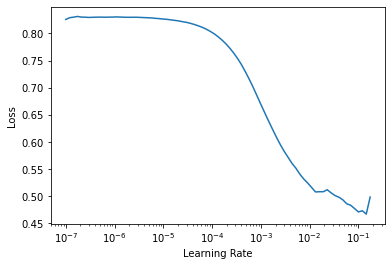

In [184]:
learn.lr_find()

In [188]:
learn.fit_one_cycle(6, 1e-3, wd=10)

epoch,train_loss,valid_loss,accuracy,time
0,0.123014,0.182309,0.965999,00:00
1,0.123798,0.126223,0.965999,00:00
2,0.122278,0.127770,0.965999,00:00
3,0.119985,0.136650,0.965999,00:00
4,0.116467,0.126195,0.965999,00:00
5,0.112235,0.123573,0.965999,00:00


In [153]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(y):
    preds = np.array(learn.get_preds()[0].squeeze())
    return r_mse(y, preds)

In [106]:
m_rmse(dls.valid_ds.y)

ValueError: operands could not be broadcast together with shapes (10676,) (10676,2) 

To get the above result I treated the classification problem isFraud=1, ~isFraud=2 as a regression problem. Used MSELoss

In [119]:
preds = learn.get_preds()[0][:,1]
preds

tensor([0.0518, 0.0761, 0.0012,  ..., 0.0188, 0.2838, 0.0410])

In [112]:
learn.get_preds()[1]

tensor([[0],
        [1],
        [0],
        ...,
        [0],
        [0],
        [0]], dtype=torch.int8)

In [78]:
learn.get_preds()[1]

tensor([[0],
        [1],
        [0],
        ...,
        [0],
        [0],
        [0]], dtype=torch.int8)

In [168]:
roc_auc_score(learn.get_preds()[1], learn.get_preds()[0][:,1])

0.8049013534764088

In [429]:
dls.xs.columns


Index(['R_emaildomain', 'M4', 'M5', 'card6', 'id_20', 'ProductCD',
       'DeviceType', 'addr2', 'id_31', 'card2', 'isFraud', 'D3_na', 'D2_na',
       'D5_na', 'D1_na', 'D8_na', 'D15_na', 'C5', 'D3', 'C14', 'C13', 'C4',
       'D2', 'C1', 'C8', 'C2', 'D5', 'C11', 'C10', 'C12', 'D1', 'D8', 'D15',
       'C6', 'TransactionDT', 'TransactionAmt'],
      dtype='object')